`LangGraph`에서 조건부 실행 흐름을 제어하는 특별한 엣지인 `conditional_edge`를 활용한 RAG
 - 특정 조건이 충족될 때만 해당 경로로 실행이 진행
 - 사용자의 입력이 특정 조건을 만족할 때만 특정 `node`로 이동하고, 그렇지 않으면 다른 경로로 진행

![agentic-rag](https://i.imgur.com/9NCNGWa.png)

In [33]:
from langchain_chroma import Chroma
from  langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embeddings,
    collection_name='income_tax_collection',
    persist_directory='./income_tax_collection' 
)

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

state 선언 및 Agent 생성

In [19]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_bulider = StateGraph(AgentState)

In [20]:
def retrieve(state: AgentState) -> AgentState:

    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [21]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [22]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm    
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response}

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


문서 관련선 판단을 위한 로직 구현
- Agent는 LLM의 판단과 의사결정을 따름

In [23]:
from langchain import hub
from langsmith import Client
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    
    query = state['query']  # 질문 추출
    context = state['context']  # 문맥 추출
    print(f'context == {context}')
    doc_relevance_chain = doc_relevance_prompt | llm    # 문서 관련성 판단 체인 구성
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})  # 쿼리와 문맥을 이용해, 문서 관련성 판단
    print(f'doc relevance responce: {response}')
    if response['Score'] == 1:  # 관련성이 높으면 'generate', 그렇지 않으면 'rewirte'
        return 'generate'
    
    return 'rewrite'

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [24]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']   # 표현 변환을 위한 사전 정의

# 프롬프트 템플릿 구성
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{query}}
""")

def rewrtie(state: AgentState) -> AgentState: # 사용자의 질문을 포함한 Agent의 현재 state
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    
    return{'query': response}    # 변경된 질문을 포함하는 state를 반환

노드 생성

In [25]:
graph_bulider.add_node('retrieve', retrieve)
graph_bulider.add_node('generate', generate)
graph_bulider.add_node('rewrite', rewrtie)

엣지 생성

In [26]:
from langgraph.graph import START, END
""""
graph_bulider.add_edge(START, 'retrieve')
graph_bulider.add_conditional_edges('retrieve', generate)
graph_bulider.add_conditional_edges('retrieve', rewrtie)
graph_bulider.add_edge('rewrite', 'retrieve')
graph_bulider.add_edge('generate', END)
"""

'"\ngraph_bulider.add_edge(START, \'retrieve\')\ngraph_bulider.add_conditional_edges(\'retrieve\', generate)\ngraph_bulider.add_conditional_edges(\'retrieve\', rewrtie)\ngraph_bulider.add_edge(\'rewrite\', \'retrieve\')\ngraph_bulider.add_edge(\'generate\', END)\n'

In [27]:
from langgraph.graph import START, END

graph_bulider.add_edge(START, 'retrieve')
graph_bulider.add_conditional_edges('retrieve', check_doc_relevance)    # -> Literal['generate', 'rewrite']: 위 셀에서 return type 지정
graph_bulider.add_edge('rewrite', 'retrieve')
graph_bulider.add_edge('generate', END)

In [28]:
graph = graph_bulider.compile()

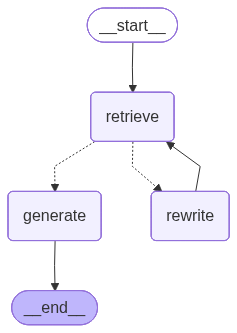

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

context == [Document(metadata={'source': '/Users/seonghoe/인프런_랭그래프/documents/income_tax.txt'}, page_content="제10조(납세지의 변동신고) 거주자나 비거주자는 제6조부터 제9조까지의 규정에 따른 납세지가 변경된 경우 변경된 날부터 15일 이내에 대변동형을 정하는 바에 따라 그 변경 후의 납세지 관할 세무서장에게 신고하여야 한다.\n  [전문개정 2009. 12. 31.]\n제11조(세무 관할) 즉서는 제6조부터 제10조까지의 규정에 따른 납세지를 관할하는 세무서장 또는 지방국세청장이 과세한다.\n  [전문개정 2009. 12. 31.]\n제2장 거주자의 종합소득 및 퇴직소득에 대한 납세의무 <개정 2009. 12. 31.>\n제3절 비과세\n  [제3절 비과세 2009. 12. 31.]\n제12조(비과세소득) 다음 각 호의 소득에 대해서는 소득세를 과세하지 아니한다. <개정 2010. 12. 27. 2011. 7. 25., 2011. 9. 15, 2012. 1. 1, 2013. 1. 1, 2013. 2. 2, 2014. 1. 1, 2014. 3. 18, 2014. 12. 15, 2016. 12. 20., 2018. 3. 20, 2018. 12. 31, 2019. 12. 10., 2019. 12. 31, 2020. 12. 29, 2022. 8. 12, 2022. 12. 31, 2023. 8. 8, 2023. 12. 31.>\n1. ‘공익신탁법’에 따른 공익재단의 이익\n  가. 농. 임. 반을 작업 생산에 이용하여 물로서 발생하는 소득\n  나. 1개 국의 주택임대소득자 주택임대소득(제99조의 규정에 따른 기준시가가 12억원을 초과하는 주택 및 국외에 소재하는 주택의 임대소득을 제외한다) 또는 해상 주택세기금의 정하는 충분금액의 합계금이 2천 만원 이하인 자의 주택임대소득의 산정 또는 해당 과세기간까지 발생하는 소득으로 한정한다.\n  다. 대변동형으로 정하는 

{'query': '거주자의 연봉 5천만 원에 대한 세금은 어떻게 되나요?',
 'context': [Document(metadata={'source': '/Users/seonghoe/인프런_랭그래프/documents/income_tax.txt'}, page_content='특소, 계좌, 계좌기 등 성명·로렌, 타박, 감정 등의 관련 용의의 제공을 발행하는 국내원천소득 또는 제119조제16조에 따른 인적욕을 제공함에 따른 국내원천소득(조세적외의 사업소득으로 규부되는 경우를 포함한다) 비거주자에게 지급하는 자는 비거주자와 국내사업장을 가지는 경우에도 제119조에 따른 원천징수를 하여야 한다. 다만, 비거주자제 제168조에 따라 사업자등록을 한 경우는 제외한다.<개정 2010. 12. 27., 2013. 1. 1., 2014. 1. 1.>\n\n⑦ 제119조제12조(승구체법, 승주투표, 소수투표권, 체육진흥투표권의 협동한다) 및 사유의 소득에 대하여 제119절을 적용할 때에는 제조세를 운동한다.<개정 2010. 12. 27.>\n비거주자가 미자산법법에 따른 제수절을 제한하는 경우에 의하여 제119조에 따른 국내원천소득의 지 기준 말미에 해당 대금을 비거주자가 일부를 바라는 경우에 비거주자가 실제하는 금액의 범위에 대해서는 원천징수를 하여야 한다.<신설 2010. 12. 27., 2014. 1. 1.>\n⑧ 제119조에서 제창까지의 규정에 따라 원천징수를 받거나 이익을 받을 경우의 한 원확 범위는 범위에 본인이 된 의인인 행위로 보아 제창까지의 부분을 적용하여 한다.<신설 2010. 12. 27.>\n⑨ 제119조제11항까지의 규정에 따르면 원천징수를 할 때에 국내원천소득의 금액에 관한 것과 일반적인 적은 기획재정부로 청내 원천징수중의 법인에게 발행하였다고 한다.<개정 2010. 12. 27.>\n③ 제119조제12조에 따른 국내원천소득은 주식 또는 출자시지를 발행법이라면 그 주식 또는 자산이념을 부여하는 것은 국가세관으로부터 대중행위를 증진시키기